In [1]:
#EDA
%matplotlib inline
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
import io
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from textblob import TextBlob, Word
import json
import os
from os.path import basename
from sklearn import preprocessing
from __future__ import division, unicode_literals
from scipy.cluster.hierarchy import fcluster
import random

#Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Misc
import warnings
warnings.filterwarnings('ignore')

In [2]:
def makeFString(title):
    return base + title + '.txt'

def makeFExtString(title, ext):
    return base + title + ext

def openFile(fName):
    with open(fName) as dFile:    
        data = json.load(dFile)
    return data

def saveData(nFile, data):
    target = open(nFile, 'w')
    target.write(data)
    target.close()
    return target

def pullTerm(data, term):
    comp = []
    for x in data:
        if term in x:
            comp += [x[term]]
    return comp
    
def analyze(bag):
    return analyzeCoSim(analyzeVectorizer(bag, 0.70, 0.05))

def analyzeVectorizer(bag, max_df, min_df):
    tfidf_vectorizer = TfidfVectorizer(max_df = max_df, min_df = min_df)
    return tfidf_vectorizer.fit_transform(bag)

def analyzeVectorizerA(bag):
    tfidf_vectorizer = TfidfVectorizer()
    return tfidf_vectorizer.fit_transform(bag)

def analyzeCoSim(bag):
    sim = []
    for x, matx in enumerate(bag):
        cos_sim = cosine_similarity(matx, bag)
        sim += cos_sim.tolist()
    return sim

In [3]:
def get_files(path):
    for (dirpath, _, filenames) in os.walk(path):
        for filename in filenames:
            yield os.path.join(dirpath, filename)
 
def getFilename(fPath):
    return basename(fPath).rsplit('.', 1)[0]

def findExtMissing(fName, ext):
    filename, file_extension = os.path.splitext(fName)
    if os.path.exists(filename + '(analysis)' + ext):
        return False
    return True

def getMissingBooks():
    files = []
    for filename in get_files('./test_assets/'):
        if '.txt' in filename and findExtMissing(filename,'.json'):
            files += [filename]
    return files

def getBooks():
    files = []
    for filename in get_files('./test_assets/'):
        if '.json' in filename:
            files += [filename]
    return files

In [4]:
def scaleIgnoreFirst(data):
    construct = []
    cols = data.columns.values
    for col in cols:
        sorted_col = pd.DataFrame(data[col])
        first = sorted_col.nlargest(2, col).iloc[0]
        second = sorted_col.nlargest(2, col).iloc[1]
        sorted_col.loc[sorted_col[col] == first[col], col] = second[col]
        construct += [sorted_col]
    new_df = pd.concat(construct, axis=1)
    return new_df

def scaleMinMax(data):
    return pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(data))

# def returnNormCS(df):
#     min_max_scaler = preprocessing.MinMaxScaler()
#     scaled = scaleIgnoreFirst(df)
#     df_phrase_scaled = min_max_scaler.fit_transform(scaled)
#     df_normalized = pd.DataFrame(df_phrase_scaled)
#     return df_normalized

In [5]:
titles = getBooks()
datum = []

for title in titles:
    data = openFile(title)
    datum += [data]

In [6]:
df_words = pd.DataFrame(analyze(pullTerm(datum,'words')))
df_sentiment = pd.DataFrame(analyze(pullTerm(datum,'sentiment')))

In [7]:
# norm_cs_words = returnNormCS(df_words)
# norm_cs_sentiment = returnNormCS(df_sentiment)
df_words = pd.DataFrame(analyze(pullTerm(datum,'words')))
df_sentiment = pd.DataFrame(analyze(pullTerm(datum,'sentiment')))

In [8]:
metas = [[x['words'], x['polarity'], x['subjectivity']] for x in pullTerm(datum,'meta')]
# print df_metas.max()
# print df_metas.min()
# df_metas.head()
# norm_cs_meta = returnNormCS(pd.DataFrame(analyzeCoSim(metas)))

In [9]:
google_metas = []
for x in pullTerm(datum,'meta'):
    info = {}
    x_goog = x['google']
    if 'title' in x_goog:
        info['title'] = x_goog['title']
    else:
        info['title'] = None
    if 'authors' in x_goog:
        info['authors'] = ', '.join(x_goog['authors'])
    else:
        info['authors'] = None
    if 'categories' in x_goog:
        info['categories'] = ' '.join(x_goog['categories'])
    else:
        info['categories'] = None
    google_metas += [info]

g_meta_df = pd.DataFrame(google_metas)
g_meta_df['files'] = [getFilename(x).replace("(analysis)","") for x in titles]
g_meta_df.head()

,authors,categories,title,files
0,None,Agriculture,The Plantation,"A M Hartnett, Carried Away - The Deep End"
1,Abigail Roux,Fiction,Ball & Chain,"Abigail Roux, Ball & Chain"
2,Adite Banerjie,Fiction,The Indian Tycoon's Marriage Deal,"Adite Banerjie, The Indian Tycoon's Marriage Deal"
3,Aharon Appelfeld,Fiction,"Suddenly, Love","Aharon Appelfeld, Suddenly, Love"
4,Alan Dean Foster,Fiction,The Force Awakens,"Alan Foster, Star Wars - The Force Awakens"


In [10]:
top = g_meta_df['categories'].value_counts().index.tolist()
top[:5]

[u'Fiction',
 u'Juvenile Fiction',
 u'Biography & Autobiography',
 u'Humor',
 u'Young Adult Fiction']

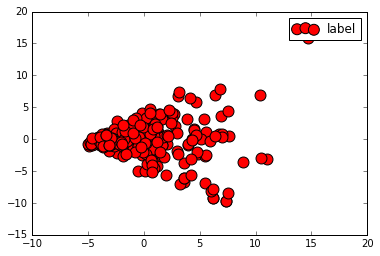

In [12]:
# Compare in all books (General)
# Compare in other books (General)
# Compare in all books (Specific)
# Compare in other books (Specific)

def getCombinedVector(words, senti):
    vect_words = analyzeVectorizer(words, .8, .05).toarray()
    vect_senti = analyzeVectorizerA(senti).toarray()
    return np.concatenate((vect_words, vect_senti), axis=1)

def getPCA(vector):
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(vector)
    return pca_results

def getLinkCluster(X, max_d):
    Z = linkage(X, 'ward')
    clusters = fcluster(Z, max_d, criterion='distance')
    return Z, clusters
    
vector = getCombinedVector(pullTerm(datum,'words'), pullTerm(datum,'sentiment'))
vector = scaleMinMax(np.concatenate((vector, metas), axis=1))
#scaled_metas
#scaled_metas = scaleMinMax(metas)
pca_df = pd.DataFrame(getPCA(vector), columns=['x','y'])
Z, clusters = getLinkCluster(vector, 45)
plt.scatter(pca_df['x'], pca_df['y'], s=120, c='r', label=str('label'))
plt.legend()

In [42]:
# bigram_vectorizer = CountVectorizer(min_df=1)
# analyze = bigram_vectorizer.build_analyzer()
# analyze(pullTerm(datum,'words')[0])

import re
REGEX = re.compile(r",\s*")
def tokenize(text):
    return [tok.strip().lower() for tok in REGEX.split(text)]

from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(analyzer = 'word')
data = vec.fit_transform(pullTerm(datum,'words')[0].split(" ")).toarray()
print data

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [44]:
import numpy as np
#np.clip(data, 0, 1, out=data)
dist = np.sum(data, axis=0)
vocab = vec.get_feature_names()

# sorted(zip(vocab, dist), key=getKey)

# for tag, count in zip(vocab, dist):
#     print count, tag

In [2]:
# from sklearn.feature_extraction.text import CountVectorizer
# def getKey(item):
#     return item[0]

# def returnTopWords(wordz, top):
#     vec = CountVectorizer(analyzer = 'word')
#     data = vec.fit_transform(wordz).toarray()
#     dist = np.sum(data, axis=0)
#     vocab = vec.get_feature_names()
#     return sorted(zip(dist, vocab), key=getKey, reverse=True)[:top]

# def returnSelectedWords(wordz, selected):
#     vec = CountVectorizer(analyzer = 'word')
#     data = vec.fit_transform(wordz).toarray()
#     dist = np.sum(data, axis=0)
#     vocab = vec.get_feature_names()
#     return [x for x in sorted(zip(dist, vocab), key=getKey, reverse=True) if x[0] > selected]

# #print returnSelectedWords(pullTerm(datum,'words')[0].split(" "), 20)
# print returnTopWords(pullTerm(datum,'words')[0].split(" "), 20)

In [1]:
# df_1 = pd.DataFrame(returnSelectedWords(pullTerm(datum,'words')[0].split(" "), 20), columns=['count','word'])
# df_2 = pd.DataFrame(returnSelectedWords(pullTerm(datum,'words')[1].split(" "), 20), columns=['count','word'])

# def compareBooks(book1, book2):
#     print "Commonalities Book 1"
#     print df_1[df_1['word'].isin(df_2['word'])][:10]
#     print "Differences Book 1"
#     print df_1[~df_1['word'].isin(df_2['word'])][:10]
#     print "Commonalities Book 2"
#     print df_2[df_2['word'].isin(df_1['word'])][:10]
#     print "Differences Book 2"
#     print df_2[~df_2['word'].isin(df_1['word'])][:10]

# # print df_1.head()
# # print df_2.head()

# #print df_1[df_1['word'].isin(df_2['word'])]
# # print df_2[df_2['word'].isin(df_1['word'])][:10]['word'].values
# compareBooks(df_1, df_2)

In [45]:
print pd.Series(clusters).value_counts()

1    205
4     31
2     30
3      2
dtype: int64


In [12]:
def dendroShow(Z):
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
    )
    plt.show()

In [13]:
def searchMeta(meta, term):
    for idx, x in enumerate(meta):
        for y in x:
            if y is not None and term.lower() in y.lower():
                return idx
    return None

def findRowsinCluster(pos, vector, clusters, meta, inverse):
    search_cluster = clusters[pos]
    n_vect = []
    n_meta = []
    for idx, x in enumerate(clusters):
        if (not inverse and x == search_cluster) or (inverse and (x != search_cluster or idx == pos)):
            n_vect += [vector[idx]]
            n_meta += [meta[idx]]
    return n_vect, n_meta

def determineCloseness(pos, data, spots, incluster, reverse):
    datay = data.sort([pos],ascending=[0]).index
    print "Book: " + getFilename(getBooks()[pos].replace("(analysis)",""))
    matches = []
    for idx, x in enumerate(datay):
        if (x != pos and ((not reverse and x in incluster) or (reverse and x not in incluster))):
            result = str(idx) + ":" + str(x) + " - "
            if "authors" in meta_fiction_all.iloc[x,:] and meta_fiction_all.iloc[x,:]["authors"] is not None:
                result += meta_fiction_all.iloc[x,:]["authors"]
            if "title" in meta_fiction_all.iloc[x,:] and meta_fiction_all.iloc[x,:]["title"] is not None:
                result += ", " + meta_fiction_all.iloc[x,:]["title"]
            result += " (" + str(round(data[pos][x],2)) + ")"
            matches += [result]
        if len(matches) >= spots:
            return matches
    return matches

def printList(listy):
    for x in listy:
        print x
    
    
n_vect, n_meta = findRowsinCluster(0, vector, clusters, g_meta_df.as_matrix(), False)
n_pca_df = pd.DataFrame(getPCA(n_vect), columns=['x','y'])
n_Z, sub_clusters = getLinkCluster(n_vect, 1.5)

Searching for term:  James S.A. Corey, Babylon's Ashes 



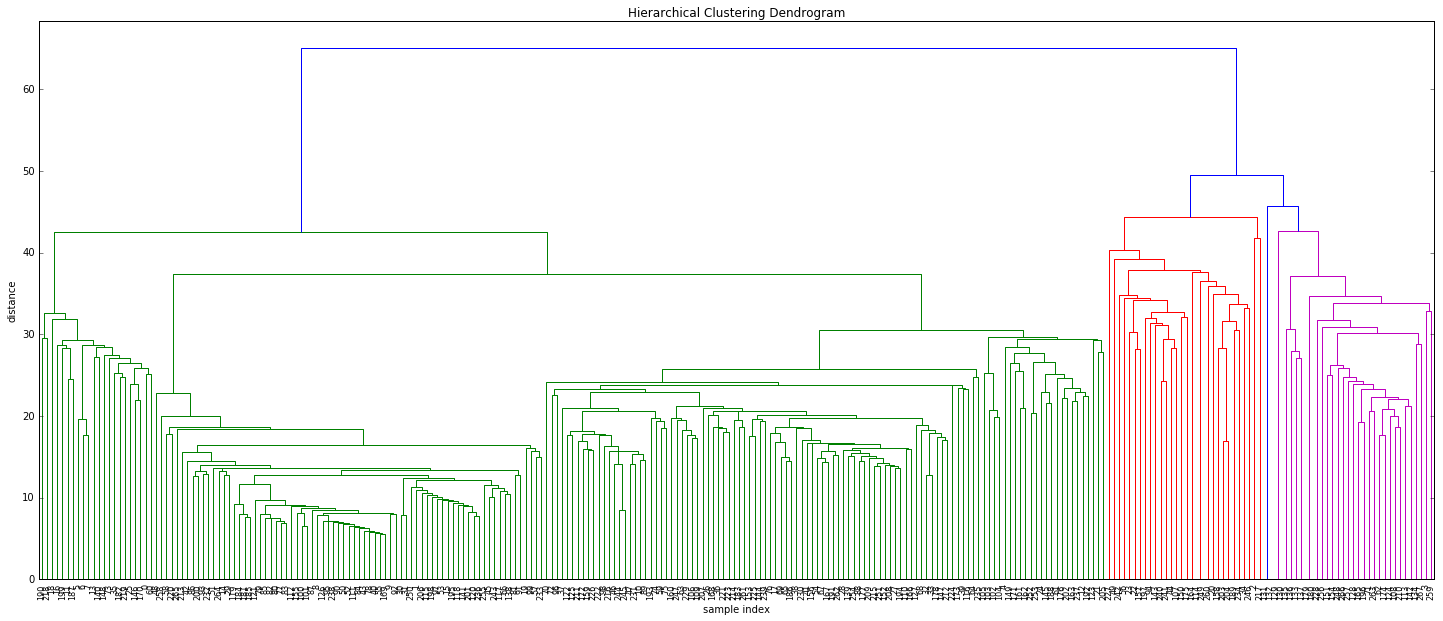

Compare to all the books in global category
0.446960316851  : D J McCune, Death & Co - The Mortal Knife
0.42767887317  : Chris Lynch, Vietnam - I Pledge Allegiance
0.417565294695  : Catherine Lanigan, Shores of Indian Lake - Love Shadows
0.413861929748  : Camille Elliot, Prelude for a Lord
0.411725680694  : Scott Nicholson, After - The Echo
0.372913125595  : Chris Weitz, Young World - The Young World
0.340234433602  : John Grisham, Rogue Lawyer
0.332221201692  : Dan Decker, War of the Fathers - Shadows of Bloodshed
0.321941014465  : Cynthia Kimball, Dating Service - Your Dimension or Mine

Compare to all the books not in global category
0.471223913413  : James Wade, Collected Stories
0.293243326771  : Captain Chesley B. Sullenberger, Highest Duty
0.281230474948  : R. Chetwynd-Hayes, Collected Stories
0.27930240552  : William Kienzle, Assault With Intent - The Father
0.238261700467  : Christianna Brand, Buffet for Unwelcome Guests
0.233553950761  : Dave Barry, Complete Guide to Guys
0.2

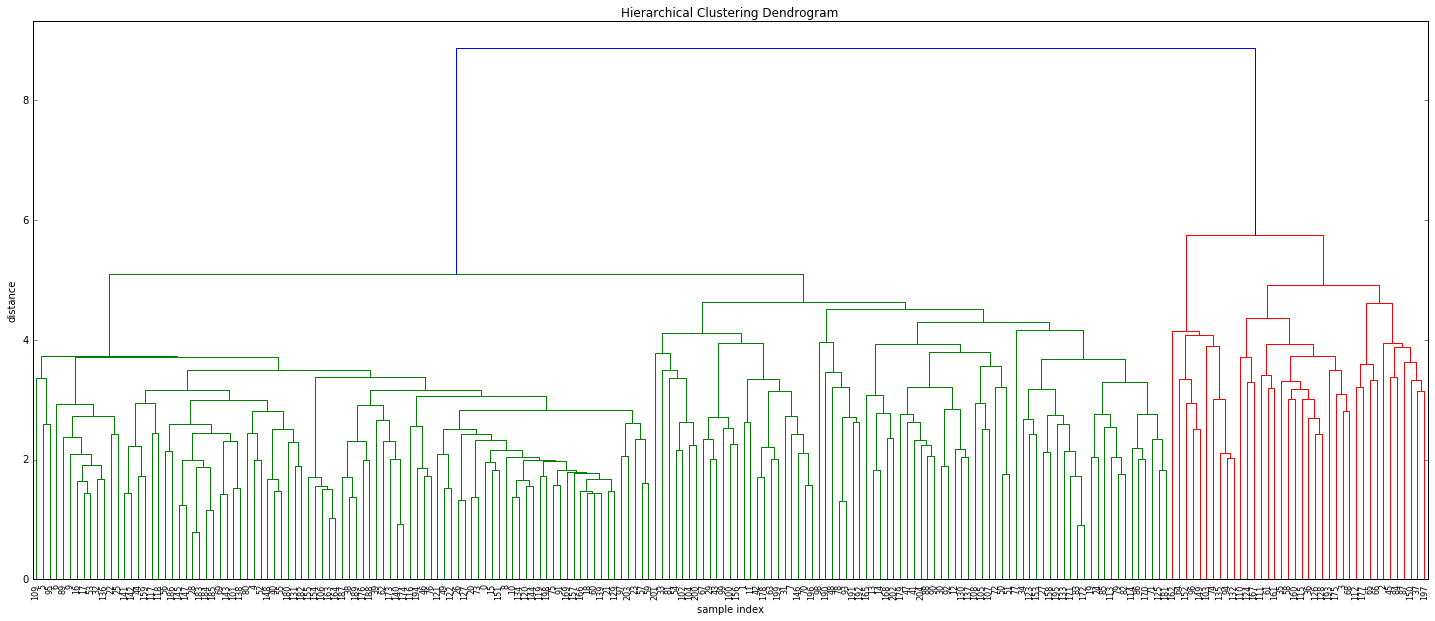


Compare to all the local books in local category
0.446960316851  : D J McCune, Death & Co - The Mortal Knife
0.42767887317  : Chris Lynch, Vietnam - I Pledge Allegiance
0.417565294695  : Catherine Lanigan, Shores of Indian Lake - Love Shadows
0.413861929748  : Camille Elliot, Prelude for a Lord
0.332221201692  : Dan Decker, War of the Fathers - Shadows of Bloodshed
0.321941014465  : Cynthia Kimball, Dating Service - Your Dimension or Mine
0.280663053645  : Barbara Steiner, The Dark Chronicles - The Calling
0.269689063595  : Victoria Hale, A Picture of Desire
0.232541622963  : Molly McGuire Woods, Barbie and the Secret Door

Compare to all the local books not in local category
0.411725680694  : Scott Nicholson, After - The Echo
0.372913125595  : Chris Weitz, Young World - The Young World
0.340234433602  : John Grisham, Rogue Lawyer
0.314665413429  : Carolyn Keene, Nancy Drew Diaries - Win, Place or Die
0.224896634106  : Kristen Middleton, Dark Realms
0.221879008137  : Bernadette Marie,

In [21]:
def getCloseness(pos, data):
    return data.sort([pos],ascending=[0]).index

def printResults(term, meta, sim_matrix, num):
    pos = searchMeta(meta, term)
    closeness = getCloseness(searchMeta(meta, term), sim_matrix)
    res = num if len(closeness) > num else len(closeness)
    for x in getCloseness(searchMeta(meta, term), sim_matrix)[1:res]:
        print sim_matrix[pos][x], " : " + meta[x][3]

def returnResults(term, meta, vector):
    print "Searching for term: " , term, "\n"
    
    #This is the global cluster
    n_pos = searchMeta(meta, term)
    Z, clusters = getLinkCluster(vector, 46)
    dendroShow(Z)
    n_vect, n_meta = findRowsinCluster(n_pos, vector, clusters, g_meta_df.as_matrix(), False)
    rn_vect, rn_meta = findRowsinCluster(n_pos, vector, clusters, g_meta_df.as_matrix(), True)
    
    global_sim_n = pd.DataFrame(analyzeCoSim(n_vect))
    global_sim_rn = pd.DataFrame(analyzeCoSim(rn_vect))
    
    print "Compare to all the books in global category"
    printResults(term, n_meta, global_sim_n, 10)
    
    print "\nCompare to all the books not in global category"
    printResults(term, rn_meta, global_sim_rn, 10)
    
    print len(n_vect)
    
    n_Z, n_clusters = getLinkCluster(n_vect, 6)
    dendroShow(n_Z)
    
    #This is the local cluster
    l_pos = searchMeta(n_meta, term)
    l_vect, l_meta = findRowsinCluster(l_pos, n_vect, n_clusters, n_meta, False)
    rl_vect, rl_meta = findRowsinCluster(l_pos, n_vect, n_clusters, n_meta, True)
    
    local_sim_l = pd.DataFrame(analyzeCoSim(l_vect))
    local_sim_rl = pd.DataFrame(analyzeCoSim(rl_vect))
    
    print "\nCompare to all the local books in local category"
    printResults(term, l_meta, local_sim_l, 10)
    
    print "\nCompare to all the local books not in local category"
    printResults(term, rl_meta, local_sim_rl, 10)

#vector = getCombinedVector(pullTerm(datum,'words'), pullTerm(datum,'sentiment'))
returnResults("James S.A. Corey, Babylon's Ashes", g_meta_df.as_matrix(), vector)

In [ ]:
# r_vect, r_meta = findRowsinCluster(0, n_vect, sub_clusters, n_meta)
# for x in r_meta:
#     print x
# # plt.scatter(pca_df['x'], pca_df['y'], s=120, c='r', label=str('label'))
# # plt.legend()

In [ ]:
# Z, clusters = getLinkCluster(getCombinedVector(pullTerm(datum,'words'), pullTerm(datum,'sentiment')))

# plt.figure(figsize=(25, 10))
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('sample index')
# plt.ylabel('distance')
# dendrogram(
#     Z,
#     leaf_rotation=90.,  # rotates the x axis labels
#     leaf_font_size=8.,  # font size for the x axis labels
# )
# plt.show()

In [15]:
top = g_meta_df['categories'].value_counts().index.tolist()[0]
fiction = g_meta_df.ix[(g_meta_df['categories']==top)]
fiction.head()

,authors,categories,title,files
1,Abigail Roux,Fiction,Ball & Chain,"Abigail Roux, Ball & Chain"
2,Adite Banerjie,Fiction,The Indian Tycoon's Marriage Deal,"Adite Banerjie, The Indian Tycoon's Marriage Deal"
3,Aharon Appelfeld,Fiction,"Suddenly, Love","Aharon Appelfeld, Suddenly, Love"
4,Alan Dean Foster,Fiction,The Force Awakens,"Alan Foster, Star Wars - The Force Awakens"
5,Alannah Carbonneau,Fiction,The Curse of Bound Blood,"Alannah Carbonneau, All Good Things Absolved"


## This is the evaluation for all the books

In [16]:
pca = PCA(n_components=2)
pca_fiction_all = pca.fit_transform(analyzeVectorizer(pullTerm(datum,'words'), .7, .05).toarray())

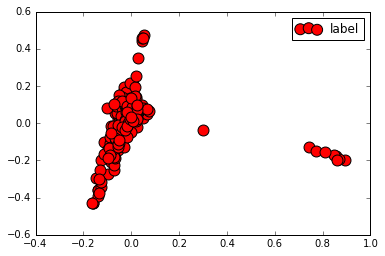

In [17]:
pca_df = pd.DataFrame(pca_fiction_all, columns=['x','y'])
plt.scatter(pca_df['x'], pca_df['y'], s=120, c='r', label=str('label'))
plt.legend()

## Where Google thinks the book's category belongs

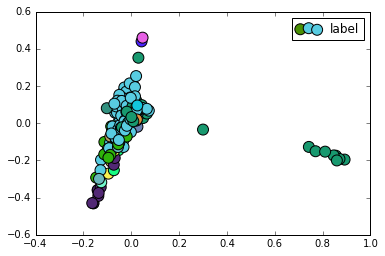

In [18]:
r = lambda: random.randint(0,255)

def getColor():
    return '#%02X%02X%02X' % (r(),r(),r())

cats = {}
for x in g_meta_df['categories'].value_counts().index.tolist():
    cats[x] = getColor()
    
pca_df['categories'] = [x for x in g_meta_df['categories']]
pca_df_n = pca_df.dropna()
pca_df_n['colors'] = [cats[x] for x in pca_df_n['categories']]

plt.scatter(pca_df_n['x'], pca_df_n['y'], s=120, c=pca_df_n['colors'], label=str('label'))
plt.legend()

## Where unsupervised learning thinks it belongs

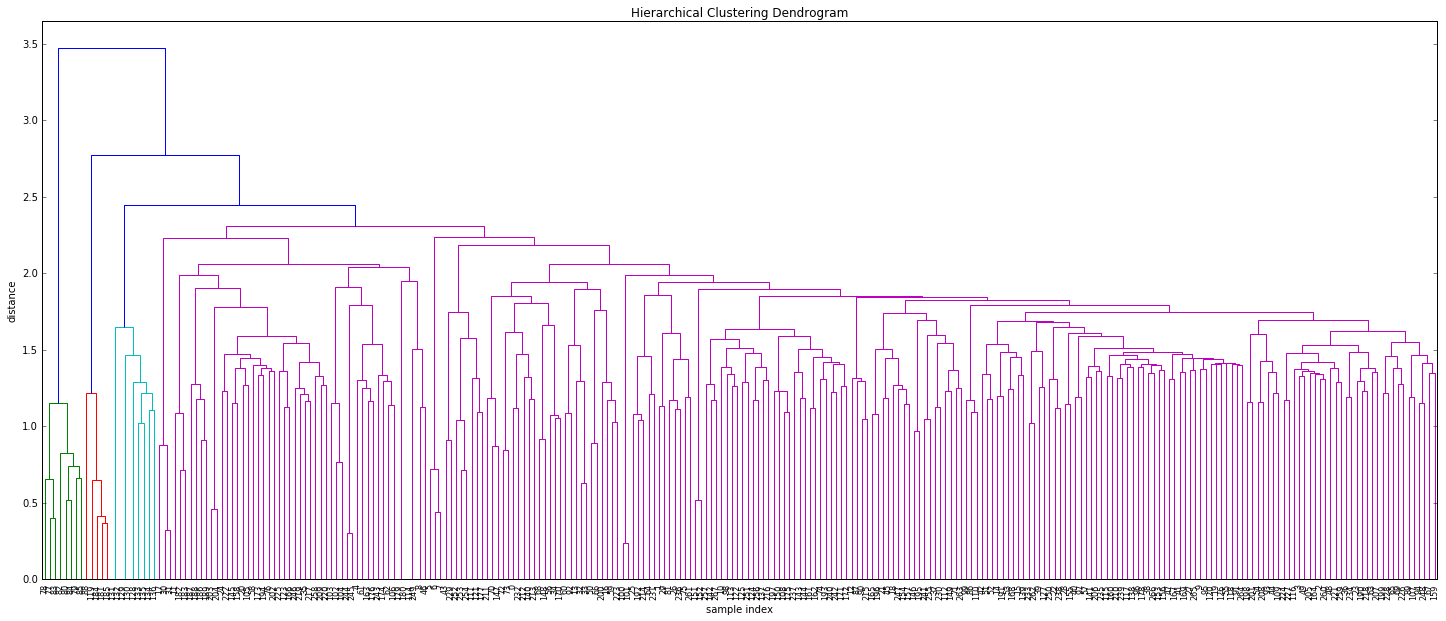

In [26]:
vectorized_words = analyzeVectorizer(pullTerm(datum,'words'), .7, .05)

X = vectorized_words.todense()
Z = linkage(X, 'ward')
max_d = 2.25
clusters = fcluster(Z, max_d, criterion='distance')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

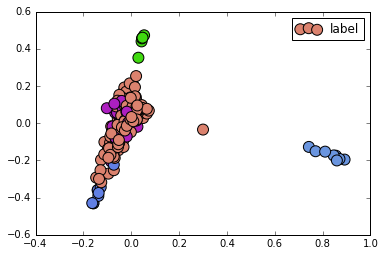

In [27]:
cats = {}
for x in pd.Series(clusters).value_counts().index.tolist():
    cats[x] = getColor()

pca_df_unsuper = pd.DataFrame(pca_df) 

pca_df_unsuper['colors'] = [cats[x] for x in clusters]
plt.scatter(pca_df_unsuper['x'], pca_df_unsuper['y'], s=120, c=pca_df_unsuper['colors'], label=str('label'))
plt.legend()

## Let's evaluate sentiment and words now

In [28]:
vect_words = analyzeVectorizer(pullTerm(datum,'words'), .80, .05).toarray()
vect_sentiment = analyzeVectorizerA(pullTerm(datum,'sentiment')).toarray()

In [29]:
all_metrics = np.concatenate((vect_words, vect_sentiment), axis=1)
pca_fiction = pca.fit_transform(all_metrics)

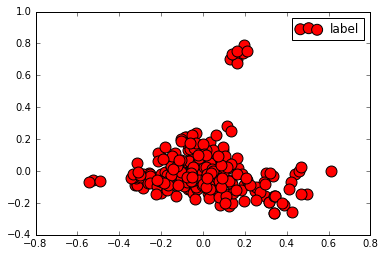

In [30]:
pca_df = pd.DataFrame(pca_fiction, columns=['x','y'])
plt.scatter(pca_df['x'], pca_df['y'], s=120, c='r', label=str('label'))
plt.legend()

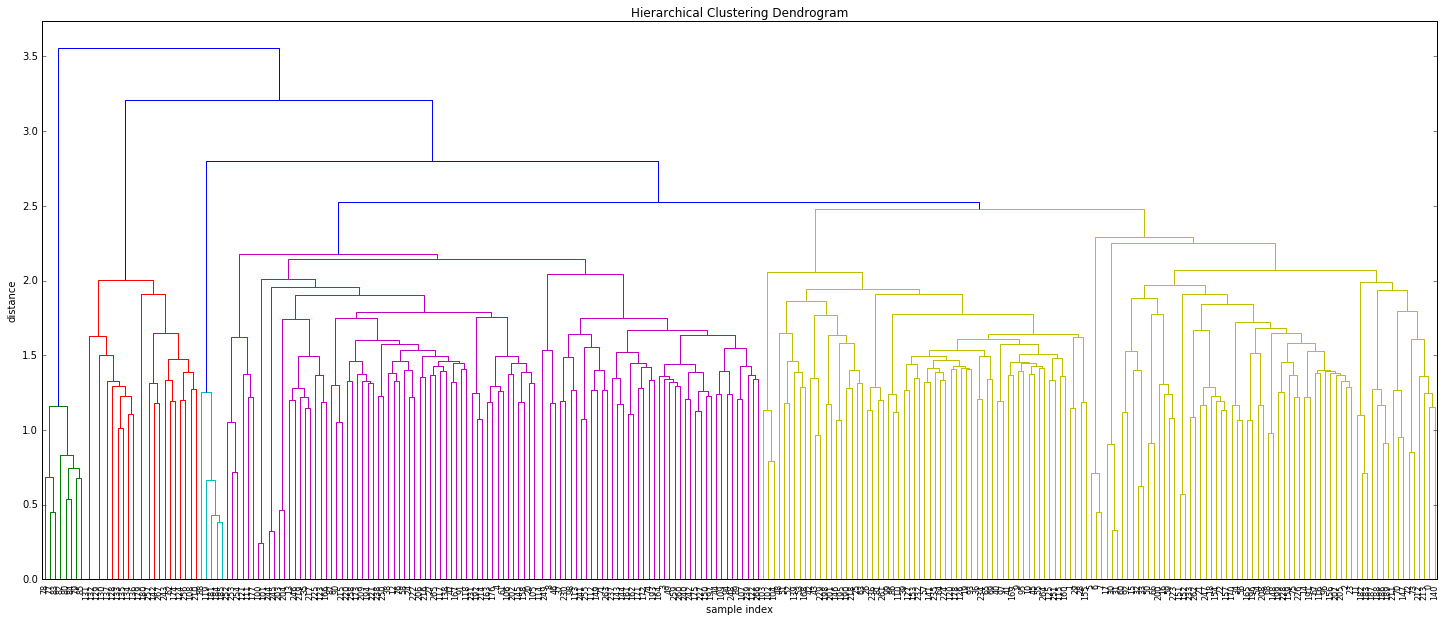

In [34]:
X = all_metrics
Z = linkage(X, 'ward')
max_d = 2.4
clusters = fcluster(Z, max_d, criterion='distance')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

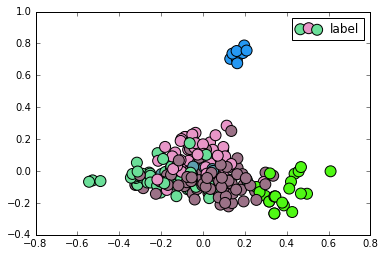

In [35]:
cats = {}
for x in pd.Series(clusters).value_counts().index.tolist():
    cats[x] = getColor()

pca_df['colors'] = [cats[x] for x in clusters]
plt.scatter(pca_df['x'], pca_df['y'], s=120, c=pca_df['colors'], label=str('label'))
plt.legend()

In [36]:
meta_fiction_all = pd.DataFrame(g_meta_df)
meta_fiction_all['cluster'] = [clusters[idx] for idx, x in meta_fiction_all.iterrows()]
print meta_fiction_all.head()

            authors   categories                              title  \
0              None  Agriculture                     The Plantation   
1      Abigail Roux      Fiction                       Ball & Chain   
2    Adite Banerjie      Fiction  The Indian Tycoon's Marriage Deal   
3  Aharon Appelfeld      Fiction                     Suddenly, Love   
4  Alan Dean Foster      Fiction                  The Force Awakens   

                                               files  cluster  
0          A M Hartnett, Carried Away - The Deep End        6  
1                         Abigail Roux, Ball & Chain        5  
2  Adite Banerjie, The Indian Tycoon's Marriage Deal        6  
3                   Aharon Appelfeld, Suddenly, Love        4  
4         Alan Foster, Star Wars - The Force Awakens        4  


In [37]:
for x in range(np.amax(meta_fiction_all["cluster"].value_counts().index.tolist())):
    print "\nCategory: ", x
    relevant = meta_fiction_all[meta_fiction_all["cluster"] == x + 1]
    for idx, y in relevant.iterrows():
        print y["authors"] , ": " , y["title"], " (", y["categories"],")"


Category:  0
Carolyn Keene :  Fatal Attraction  ( Juvenile Fiction )
Carolyn Keene :  Curse of the Arctic Star  ( Juvenile Fiction )
Carolyn Keene :  Curse of the Arctic Star  ( Juvenile Fiction )
Carolyn Keene :  Curse of the Arctic Star  ( Juvenile Fiction )
Carolyn Keene :  Curse of the Arctic Star  ( Juvenile Fiction )
Carolyn Keene :  Curse of the Arctic Star  ( Juvenile Fiction )
Carolyn Keene :  The Red Slippers  ( Juvenile Fiction )
Carolyn Keene :  Strangers on a Train  ( Juvenile Fiction )

Category:  1
Brian Kilmeade, Don Yaeger :  Thomas Jefferson and the Tripoli Pirates  ( History )
Christopher Simpson :  Blowback  ( History )
Dan E. Moldea :  Interference  ( Sports & Recreation )
Dave Barry :  Best. State. Ever.  ( Humor )
Dave Barry :  Boogers Are My Beat  ( Humor )
Dave Barry :  Boogers Are My Beat  ( Humor )
Dave Barry :  Dave Barry's Complete Guide to Guys  ( Humor )
Dave Barry :  Dave Barry's Complete Guide to Guys  ( Humor )
Dave Barry :  Dave Barry Is Not Making T

In [38]:
all_metrics_sim = pd.DataFrame(analyzeCoSim(all_metrics))
norm_all_metrics = all_metrics_sim

In [42]:
# Determine the closest for all books in cluster
# b) out of cluster
# Determine the closest for books in genre in cluster
# b) out of cluster

meta_fiction_all.iloc[74,:]["cluster"]
incluster = [idx for idx,x in meta_fiction_all.iterrows() if x["cluster"] == meta_fiction_all.iloc[74,:]["cluster"]]

def determineCloseness(pos, data, spots, incluster, reverse):
    datay = data.sort([pos],ascending=[0]).index
    print "Book: " + getFilename(getBooks()[pos].replace("(analysis)",""))
    matches = []
    for idx, x in enumerate(datay):
        if (x != pos and ((not reverse and x in incluster) or (reverse and x not in incluster))):
            result = str(idx) + ":" + str(x) + " - "
            if "authors" in meta_fiction_all.iloc[x,:] and meta_fiction_all.iloc[x,:]["authors"] is not None:
                result += meta_fiction_all.iloc[x,:]["authors"]
            if "title" in meta_fiction_all.iloc[x,:] and meta_fiction_all.iloc[x,:]["title"] is not None:
                result += ", " + meta_fiction_all.iloc[x,:]["title"]
            result += " (" + str(round(data[pos][x],2)) + ")"
            matches += [result]
        if len(matches) >= spots:
            return matches
    return matches

def printList(listy):
    for x in listy:
        print x
 
print "Closest in global cluster"
printList(determineCloseness(54, norm_all_metrics, 10, incluster, False))
print "\nClosest outside global cluster"
printList(determineCloseness(54, norm_all_metrics, 10, incluster, True))

Closest in global cluster
Book: Beth Pattillo, Sweetgum - The Sweetgum Knit Lit Society
2:109 - Claire Zorn, The Protected (Large Print 16pt) (0.65)
3:74 - Carl Hiaasen, Razor Girl (0.62)
4:105 - Chris Lynch, World War II Book 1: The Right Fight (0.6)
7:263 - Tom Rinaldi, The Red Bandanna (0.54)
11:149 - Fern Michaels, A Family Affair (0.53)
13:217 - Michele Barrow-Bélisle, Beautiful Babies (0.53)
15:227 - Paul Bailey, A Dog's Life (0.53)
17:240 - Ron Carlson, A Kind of Flying: Selected Stories (0.53)
18:241 - Ron Carlson, At the Jim Bridger (0.53)
19:161 - James Patterson, Cross Justice (0.52)

Closest outside global cluster
Book: Beth Pattillo, Sweetgum - The Sweetgum Knit Lit Society
1:208 - M.L. Stedman, The Light Between Oceans (0.66)
5:157 - Jack Canfield, Mark Victor Hansen, Chicken Soup for the Teenage Soul The Real Deal School (0.55)
6:56 - Bill Pronzini, Nemesis (0.54)
8:22 - Amy Schumer, The Girl with the Lower Back Tattoo (0.53)
9:196 - Leah Remini, Rebecca Paley, Troublema

In [40]:
def findMatchCluster(pos):
    meta_fiction_all = pd.DataFrame(g_meta_df)
    meta_fiction_all['cluster'] = [clusters[idx] for idx, x in meta_fiction_all.iterrows()]
    print meta_fiction_all.head()
    meta_fiction_all.iloc[74,:]["cluster"]

In [41]:
incluster = [idx for idx,x in meta_fiction_all.iterrows() if x["cluster"] == meta_fiction_all.iloc[74,:]["cluster"]]
meta_fiction_this = meta_fiction_all.iloc[incluster]

all_metrics_sim = pd.DataFrame(analyzeCoSim(all_metrics[incluster]))
norm_all_metrics = returnNormCS(all_metrics_sim)

def determineCloseness(pos, data, spots):
    datay = data.sort([pos],ascending=[0]).index
    print pos
    print datay
    print "Book: " + getFilename(getBooks()[pos].replace("(analysis)",""))
    for idx, x in enumerate(datay[:spots]):
        if (x != pos):
            print str(idx) + ":" + str(x) + " - "+ meta_fiction_this.iloc[x,:]["authors"] + ", " + meta_fiction_this.iloc[x,:]["title"]+ " (" + str(round(data[pos][x],2)) + ")"
 
print "Closest in global cluster"
#print norm_all_metrics.iloc[15]
print meta_fiction_this.iloc[1]
determineCloseness(15, norm_all_metrics, 10)
# print "\nClosest outside global cluster"
# determineCloseness(74, norm_all_metrics, 25, incluster, True)

NameError: name 'returnNormCS' is not defined

## This is the evaluation for all the fiction books

In [ ]:
indices = g_meta_df.ix[(g_meta_df['categories']==top)].index.tolist()
pca = PCA(n_components=2)
#pca_fiction = pca.fit_transform(df_words.iloc[indices,:])
pca_fiction = pca.fit_transform(analyzeVectorizer(pullTerm(datum,'words'), .7, .05).toarray()[indices,:])

In [ ]:
pca_df = pd.DataFrame(pca_fiction, columns=['x','y'])
plt.scatter(pca_df['x'], pca_df['y'], s=120, c='r', label=str('label'))
plt.legend()

In [ ]:
vectorized_words = analyzeVectorizer(word_temp.iloc[indices,:][0], .7, .05)

X = vectorized_words.todense()
Z = linkage(X, 'ward')
max_d = 1.6
clusters = fcluster(Z, max_d, criterion='distance')
#meta_fiction = fiction.reset_index()

# for idx, x in meta_fiction.iterrows():
#     print "(" + str(idx) + "," + str(clusters[idx]) + ") " + x['authors'] + ": " + x['title']
    
# r = lambda: random.randint(0,255)

# def getColor():
#     return '#%02X%02X%02X' % (r(),r(),r())

cats = {}
for x in pd.Series(clusters).value_counts().index.tolist():
    cats[x] = getColor()

pca_df['colors'] = [cats[x] for x in clusters]
plt.scatter(pca_df['x'], pca_df['y'], s=120, c=pca_df['colors'], label=str('label'))
plt.legend()

## Now let's see if adding sentiment helps...

In [ ]:
vect_words = analyzeVectorizer(pullTerm(datum,'words'), .85, .05).toarray()[indices,:]
vect_sentiment = analyzeVectorizerA(pullTerm(datum,'sentiment')).toarray()[indices,:]

In [ ]:
all_metrics = np.concatenate((vect_words, vect_sentiment), axis=1)
pca_fiction = pca.fit_transform(all_metrics)

In [ ]:
pca_df = pd.DataFrame(pca_fiction, columns=['x','y'])
plt.scatter(pca_df['x'], pca_df['y'], s=120, c='r', label=str('label'))
plt.legend()

In [ ]:
X = all_metrics
Z = linkage(X, 'ward')
max_d = 1.7
clusters = fcluster(Z, max_d, criterion='distance')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [ ]:
cats = {}
for x in pd.Series(clusters).value_counts().index.tolist():
    cats[x] = getColor()

pca_df['colors'] = [cats[x] for x in clusters]
plt.scatter(pca_df['x'], pca_df['y'], s=120, c=pca_df['colors'], label=str('label'))
plt.legend()

In [ ]:
meta_fiction = g_meta_df.iloc[indices,:].reset_index()
for idx, x in meta_fiction.iterrows():
    print "[", clusters[idx] , "] ", x['authors'] + ": " + x['title'] , "(" , round(pca_df.iloc[idx]['x'],2) , "," , round(pca_df.iloc[idx]['y'],2) , ")"

## PCA and clustering

In [ ]:
indices = g_meta_df.ix[(g_meta_df['categories']==top)].index.tolist()
word_temp = pd.DataFrame(pullTerm(datum,'words'))
vectorized_words = analyzeVectorizer(word_temp.iloc[indices,:][0], .7, .05)

In [ ]:
meta_fiction = fiction.reset_index()
for idx, x in meta_fiction.iterrows():
    print x['authors'] + ": " + x['title'] 
    print "(" , round(pca_df.iloc[idx]['x'],2) , "," , round(pca_df.iloc[idx]['y'],2) , ")"

In [ ]:
X = vectorized_words.todense()
Z = linkage(X, 'ward')
c, coph_dists = cophenet(Z, pdist(X))
c

In [ ]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [ ]:
max_d = 1.6
clusters = fcluster(Z, max_d, criterion='distance')
for idx, x in meta_fiction.iterrows():
    print "(" + str(idx) + "," + str(clusters[idx]) + ") " + x['authors'] + ": " + x['title']

In [ ]:
X = book1_finished.drop('cat',axis=1)

X = analyzeVectorizer(bag, max_df, min_df)

pca = PCA(n_components=2)
pca1 = pca.fit_transform(X)

X = book2_finished.drop('cat',axis=1)
pca2 = pca.fit_transform(X)
X = book3_finished.drop('cat',axis=1)
pca3 = pca.fit_transform(X)



In [ ]:
#weights = [96,0,2,2]
weights = [6,1,4]
df_all = ((norm_cs_words * weights[0]) + (norm_cs_sentiment * weights[1]) + (norm_cs_meta * weights[2])) / np.sum(weights)  

In [ ]:
def determineCloseness(pos, data, spots):
    datay = data.sort([pos],ascending=[0]).index
    print "Book: " + getFilename(getBooks()[pos].replace("(analysis)",""))
    for idx, x in enumerate(datay[:spots]):
        if (x != pos):
            print str(idx) + ":" + str(x) + " - "+ getFilename(getBooks()[x].replace("(analysis)","")) + " (" + str(round(data[pos][x],2)) + ")"
        
determineCloseness(74, df_all, 15)

In [ ]:
# from __future__ import division, unicode_literals
# import math

# def tf(word, blob):
#     return blob.words.count(word) / len(blob.words)

# def n_containing(word, bloblist):
#     return sum(1 for blob in bloblist if word in blob.words)

# def idf(word, bloblist):
#     return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

# def tfidf(word, blob, bloblist):
#     return tf(word, blob) * idf(word, bloblist)

In [ ]:
left = pullTerm([datum[42]],'words')[0]
right = pullTerm([datum[74]],'words')[0]
bloblist = [left,right]

tfidf_vectorizer = TfidfVectorizer(max_features=10)
matrix = tfidf_vectorizer.fit_transform(bloblist)
top_features = tfidf_vectorizer.vocabulary_
n = len(top_features)
print top_features

# insert the emoticons into the vocabulary of common features
#emoticons = {":)":0, ":P":1, ":(":2)}
#for feature, index in emoticons.items():
#    top_features[feature] = n + index

# re-vectorize using both sets of features
# at this point len(top_features) == 13
#vect = TfidfVectorizer(vocabulary=top_features)
#matrix = vect.fit_transform(traindata)

In [ ]:
#Find the most frequently occuring word in the first file that is also present in all the other documents
from sklearn.feature_extraction import text 

my_stops = ['said','just','did','going','wa','let']

stop_words = text.ENGLISH_STOP_WORDS.union(my_stops)

left = pullTerm(datum[70:75],'words')
lectures = left
vectorizer = TfidfVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(lectures)
indices = np.argsort(vectorizer.idf_)
# print len(indices)
features = vectorizer.get_feature_names()
top_n = 100
top_features = [(features[i],vectorizer.idf_[i]) for i in indices[:top_n]]
# print top_features

In [ ]:
import operator

check = TextBlob(pullTerm([datum[74]],'words')[0])
x = check.word_counts
sorted_x = sorted(x.items(), key=operator.itemgetter(1))[::-1]

joined_features = [features[i] for i in indices if vectorizer.idf_[i] == 1]
top = []
maxTop = 50

for x in sorted_x:
    if x[0] in joined_features:
        top += [x]
    if len(top) > maxTop:
        break

print top
# for x in top_features:
#     print check.

In [ ]:
for x in pullTerm(datum[40:43],'words'):
    check = TextBlob(x)
    print check.words.count('like')

In [ ]:
test = pullTerm([datum[74]],'words')[0]

vectorizer2 = TfidfVectorizer(stop_words=stop_words)
X = vectorizer2.fit_transform([test])
indices = np.argsort(vectorizer.idf_)[::-1]
# print len(indices)
features = vectorizer.get_feature_names()
top_n = 50
top_features = [(features[i],vectorizer.idf_[i]) for i in indices[:top_n]]
print top_features

In [ ]:
list = pd.DataFrame([getFilename(x.replace("(analysis)","")) for x in getBooks()], columns=["Name"])

In [ ]:
def searchLibrary(search):
    return list[list["Name"].str.contains(search)]
    
print searchLibrary("Arabella Rose")

In [ ]:
# df_all.ix[20:75,20:75]

In [ ]:
# df_words.ix[30:40,30:40]

In [ ]:
datum[74]["meta"]

In [ ]:
datum[125]["meta"]

In [ ]:
datum[4]["meta"]

In [ ]:
norm_cs_meta[74]